# Flight Price Prediction
---

# Regression Problem--> SOLVING USING Random Forest Regressor

## Steps WHICH USED TO SOLVE THIS PROBLEM:

1. Importing the dependencies
2. Importing Dataset
3. Data Preprocessing
4. Exploratory Data Analysis(EDA)
5. Handling Categorical Data
6. Test Set
7. Feature Selection
8. Fitting Model Using Random Forest
9. Website
10. Deployment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Importing dataset

1. Since data is in form of excel file we have to use pandas read_excel to load the data
2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3. Check whether any null values are there or not. if it is present then following can be done,
    1. Imputing data using Imputation method in sklearn
    2. Filling NaN values with mean, median and mode using fillna() method
4. Describe data --> which can give statistical analysis

In [2]:
train_data = pd.read_excel(r"Data_Train.xlsx")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Data Analysis using Pandas-Profiling

In [5]:
#!pip install pandas-profiling

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_data,title = "Pandas Profiling Report")
profile

# Data Preprocessing

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [8]:
train_data.shape

(10683, 11)

In [9]:
train_data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [10]:
train_data["Duration"].value_counts()

2h 50m     550
1h 30m     386
2h 55m     337
2h 45m     337
2h 35m     329
          ... 
28h 30m      1
4h 10m       1
13h 35m      1
36h 25m      1
30h 25m      1
Name: Duration, Length: 368, dtype: int64

In [11]:
train_data.dropna(inplace = True)

In [12]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

---

## EDA(Exploratory Data Analysis)

From description we can see that Date_of_Journey is a object data type,\
Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas **to_datetime** to convert object data type to datetime dtype.

<span style="color: red;">**.dt.day method will extract only day of that date**</span>\
<span style="color: red;">**.dt.month method will extract only month of that date**</span>

In [13]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

In [14]:
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [15]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [16]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [17]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [18]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [19]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [20]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [21]:
# Time taken by plane to reach destination is called Duration
# It is the differnce between Departure Time and Arrival time


# Assigning and converting Duration column into list
#preproceesing the duration
duration = list(train_data['Duration'])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  

for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))
    
train_data['Duration_hours'] = dur_hours
train_data['Duration_minutes'] =dur_minutes


In [22]:
train_data.drop(["Duration"], axis = 1, inplace = True)

In [23]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


---

## Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are,
1. <span style="color: blue;">**Nominal data**</span> --> data are not in any order --> <span style="color: green;">**OneHotEncoder**</span> is used in this case
2. <span style="color: blue;">**Ordinal data**</span> --> data are in order --> <span style="color: green;">**LabelEncoder**</span> is used in this case

In [24]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

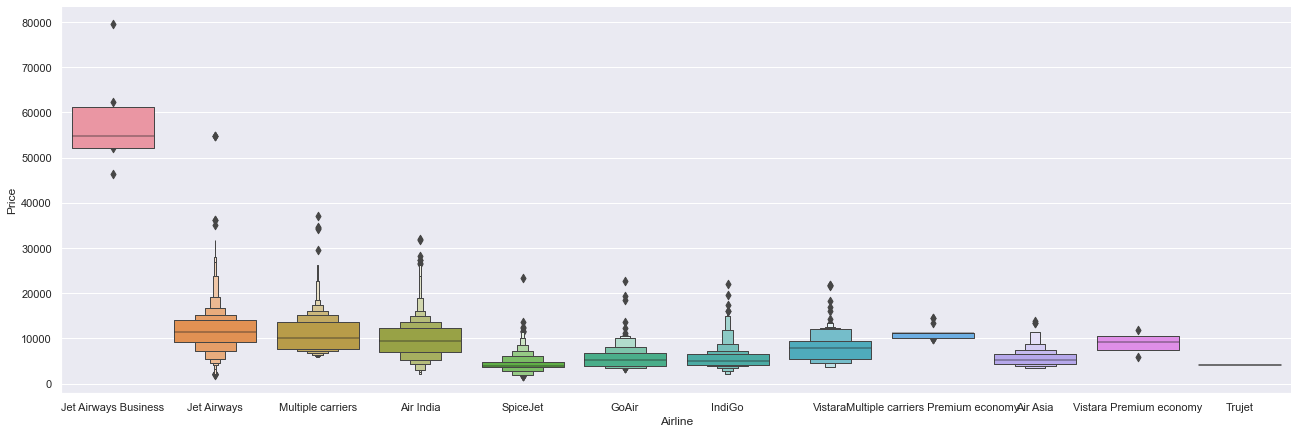

In [25]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [26]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [27]:
train_data["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

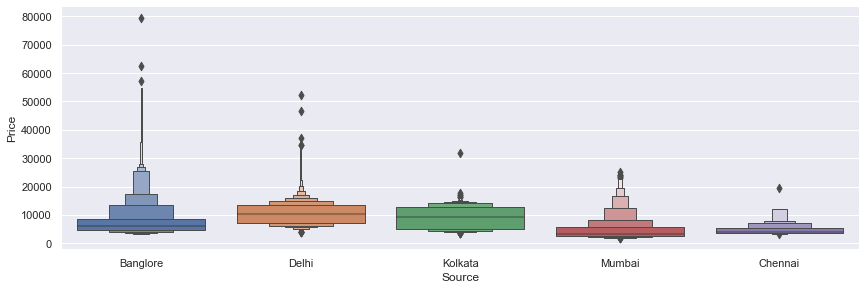

In [28]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [29]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = train_data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [30]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [31]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [32]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [33]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [34]:
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [35]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [36]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [37]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [38]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [40]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
data_train.shape

(10682, 30)

---

## Test set

In [42]:
test_data = pd.read_excel(r"Test_set.xlsx")

In [43]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [44]:
# Preprocessing

print("Test data Info")
print("-"*75)
print(test_data.info())

print()
print()

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
# Time taken by plane to reach destination is called Duration
# It is the differnce between Departure Time and Arrival time


# Assigning and converting Duration column into list
#preproceesing the duration
duration = list(test_data['Duration'])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  

for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))
    
test_data['Duration_hours'] = dur_hours
test_data['Duration_minutes'] =dur_minutes



# Adding Duration column to test set

test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)



Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time         

In [45]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


---

## Feature Selection

Finding out the best feature which will contribute and have good relation with target variable.
Following are some of the feature selection methods,


1. <span style="color: purple;">**heatmap**</span>
2. <span style="color: purple;">**feature_importance_**</span>
3. <span style="color: purple;">**SelectKBest**</span>

In [46]:
data_train.shape

(10682, 30)

In [47]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_minutes', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [48]:
X = data_train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_minutes', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [49]:
y = data_train.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

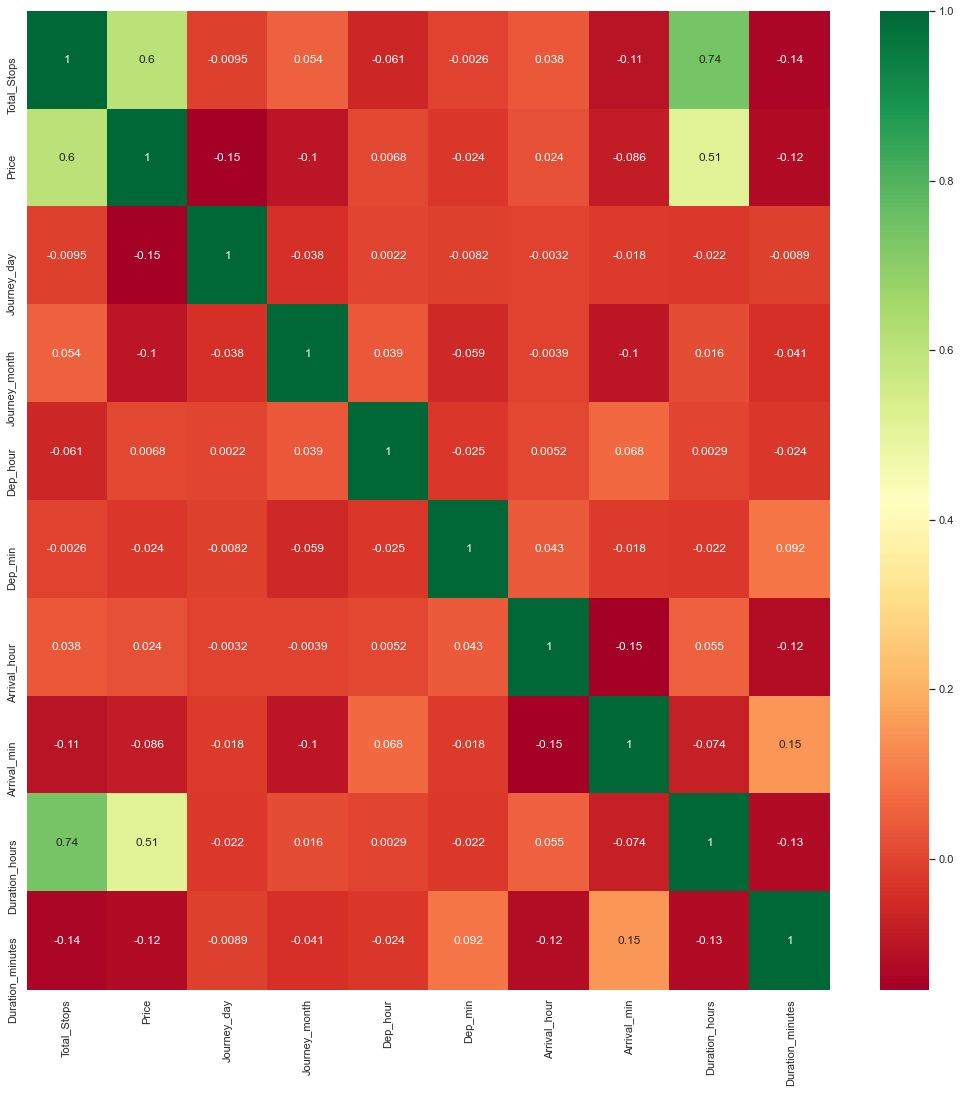

In [50]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [51]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

In [52]:
print(selection.feature_importances_)

[2.10956612e-01 1.44299098e-01 5.28914850e-02 2.38959680e-02
 2.15249795e-02 2.79622019e-02 1.89115067e-02 1.26532939e-01
 1.77899814e-02 1.05164195e-02 1.49788491e-03 1.67904438e-02
 1.48464615e-01 6.78289826e-02 1.94967454e-02 8.89423700e-04
 2.57487393e-03 9.50844839e-05 5.28776555e-03 9.08990341e-05
 4.15203702e-04 1.11100314e-02 3.29458543e-03 6.05109892e-03
 1.04730055e-02 1.80772552e-02 7.05036360e-03 4.19231401e-04
 2.48113151e-02]


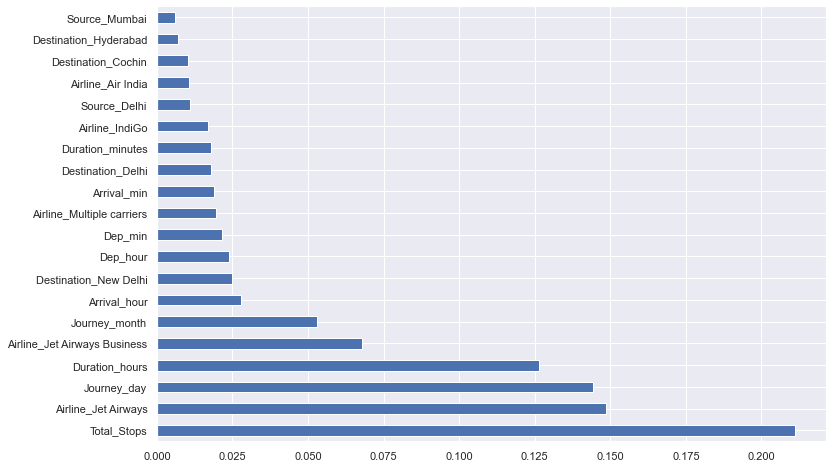

In [53]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


---

## Fitting model using Random Forest

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [55]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [56]:
y_pred = reg_rf.predict(X_test)

In [57]:
reg_rf.score(X_train, y_train)

0.9535288515510004

In [58]:
reg_rf.score(X_test, y_test)

0.7988169997703467

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


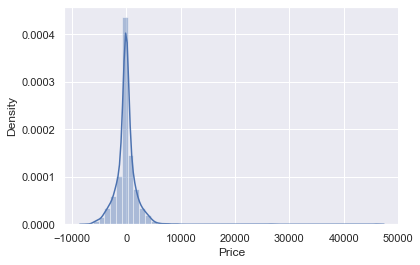

In [59]:
sns.distplot(y_test-y_pred)
plt.show()

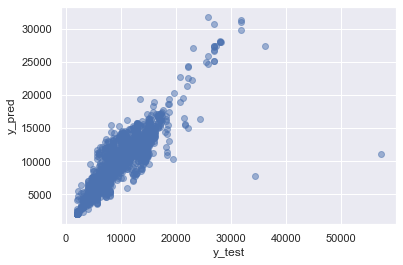

In [60]:

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [61]:
from sklearn import metrics

In [62]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1168.829721554261
MSE: 4337919.182415637
RMSE: 2082.7671935229914


In [63]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [64]:
metrics.r2_score(y_test, y_pred)

0.7988169997703467

---

## Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [65]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [67]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [68]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [69]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   7.6s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  11.1s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.1s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [70]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [71]:
prediction = rf_random.predict(X_test)

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


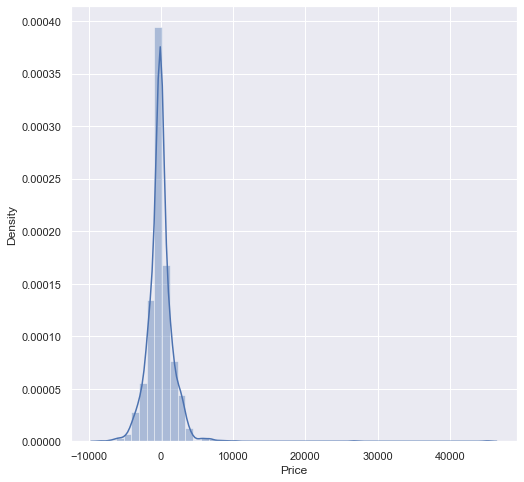

In [72]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

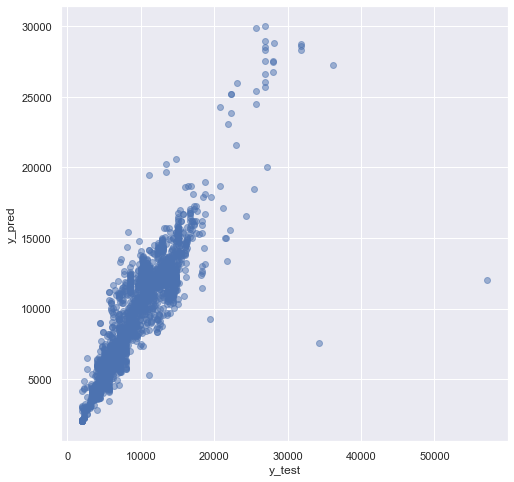

In [73]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [74]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1162.9266840106884
MSE: 4043789.227149317
RMSE: 2010.9175087877964


---

## Save the model to reuse it again

In [79]:
import pickle
# open a file, where you ant to store the data
file = open('flight_price.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [80]:
model = open('flight_price.pkl','rb')
forest = pickle.load(model)

In [81]:
y_prediction = forest.predict(X_test)

In [82]:
metrics.r2_score(y_test, y_prediction)

0.8124580899727096

---